In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import pandas as pd
import bz2
import numpy as np
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#STOPWORDS = set(stopwords.words('english'))
import csv

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner","textcat"])

def preprocess(text):
    return ' '.join(tok.text for tok in nlp(text) if tok.is_alpha and not tok.is_stop).lower()

In [9]:
lyrics = []
genre = []

with open("lyrics_01_09.csv", 'r',encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        genre.append(row[24])
        lyric = preprocess(row[0]) 
        lyrics.append(lyric)

In [10]:
genre = [i if i != "go-go" else "gogo" for i in genre]  
genre = [i if i != "doo-wop" else "doowop" for i in genre] 

In [65]:
# TODO USE random
import numpy as np
from sklearn.model_selection import train_test_split
X_train,X_val_test,Y_train,Y_val_test = train_test_split(lyrics,
                                                 genre,
                                                 test_size=0.15,
                                                 random_state= 12345)

X_test,X_val,Y_test,Y_val = train_test_split(X_val_test,
                                                 Y_val_test,
                                                 test_size=0.75,
                                                 random_state= 43125)

#from sklearn.preprocessing import LabelEncoder
##le = LabelEncoder()
#genre_le = le.fit_transform(genre)

train_lyrics = np.asarray(X_train)
train_genre = np.asarray(Y_train)

validation_lyrics = np.asarray(X_val)
validation_genre = np.asarray(Y_val)

test_lyrics = np.asarray(X_test)
test_genre = np.asarray(Y_test)

In [66]:
print(f"train lyrics {len(train_lyrics)}")# 11450
print("train genre", len(train_genre))
print("validation lyrics", len(validation_lyrics))
print("validation genre", len(validation_genre))
print("test lyrics", len(test_lyrics))
print("test genre", len(test_genre))

train lyrics 22875
train genre 22875
validation lyrics 3028
validation genre 3028
test lyrics 1009
test genre 1009


In [13]:
lyrics[0]

'long eating drinking merry strange strange taking great mongol ancestors names vain strange strange honor oath destiny strange strange valuable ethics ancestors worthless strange strange hey traitor kneel hey prophecies declared born ancestor fate sleeping deeply awakened strange strange blindly declaring mongols best strange strange born live nobles unite strange strange difficult rise nation strange strange hey traitor kneel hey prophecies declared hard cherish ancestors inherited land strange strange priceless edifications elders turning ashes strange strange future eternal prosperity wolf totemed mongols blessings heaven born undeniable fate gather nations lord chinggis declares earth come come oh black banner awakened awakened oh khanate royal power rise rise forever strange strange oh black banner awakened awakened oh khanate royal power rise rise forever'

In [39]:
# train pipeline
pipe = Pipeline([('vectorizer', CountVectorizer(analyzer='word',max_features=10000)),
                 ('predictor', MultinomialNB(alpha=4))])
pipe.fit(train_lyrics, train_genre)
# predict
test_pred = pipe.predict(test_lyrics)
print(classification_report(test_genre, test_pred, zero_division =0))

                      precision    recall  f1-score   support

alternativeamericana       0.25      0.27      0.26        56
               blues       0.00      0.00      0.00        23
               bmore       0.50      0.08      0.14        24
               chill       0.17      0.06      0.08        18
             country       0.33      0.44      0.38        16
              doowop       0.67      0.35      0.46        23
                folk       0.20      0.03      0.06        31
                gogo       0.00      0.00      0.00        17
            hardglam       0.38      0.23      0.29        13
              hiphop       0.30      0.51      0.37        51
               house       0.29      0.10      0.15        40
               indie       0.35      0.21      0.26       106
               metal       0.51      0.68      0.58       134
           nuelectro       0.00      0.00      0.00        12
                 pop       0.37      0.53      0.44       245
       

In [61]:
alpha = [i/10 for i in range(100)]
alpha[0] = 1.0e-10
hist_val = []
hist_train = []
for a in alpha:
    pipe = Pipeline([('vectorizer', CountVectorizer(analyzer='word',max_features=10000)),
                     ('predictor', MultinomialNB(alpha=a))])
    pipe.fit(train_lyrics, train_genre)
    # predict
    test_pred = pipe.predict(validation_lyrics)
    train_pred = pipe.predict(train_lyrics)
    hist_train.append(f1_score(train_genre,train_pred, average='micro'))
    f1_val = f1_score(validation_genre,test_pred, average='micro')
    hist_val.append(f1_val)
    if a % 1 == 0:
        print(a *10,"%, f1-score:",f1_val)

print(a * 10,"%, f1-score:",f1_val)

10.0 %, f1-score: 0.34544253632760896
20.0 %, f1-score: 0.3513870541611625
30.0 %, f1-score: 0.35964332892998685
40.0 %, f1-score: 0.36228533685601055
50.0 %, f1-score: 0.36492734478203437
60.0 %, f1-score: 0.3652575957727874
70.0 %, f1-score: 0.3632760898282695
80.0 %, f1-score: 0.36228533685601055
90.0 %, f1-score: 0.35997357992073975
99.0 %, f1-score: 0.3583223249669749


In [54]:
best_alpha = alpha[np.argmax(hist_val)]
print(alpha[np.argmax(hist_val)])
print(alpha[np.argmax(hist_val)])


5.5
5.5


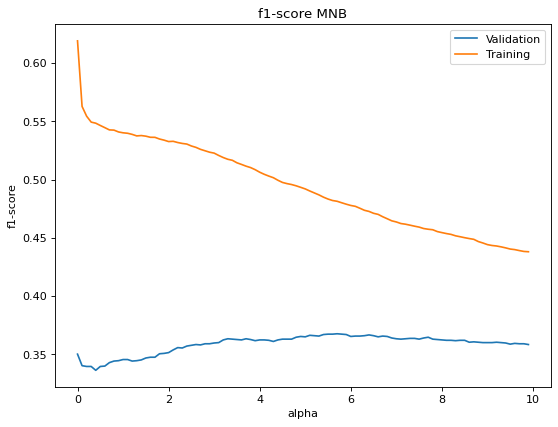

In [62]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(alpha,hist_val,label="Validation");
plt.plot(alpha,hist_train, label="Training")
plt.legend(loc="upper right")
plt.title('f1-score MNB')
plt.xlabel('alpha')
plt.ylabel('f1-score');
plt.savefig("images/mnb_f1.png")

In [67]:
pipe = Pipeline([('vectorizer', CountVectorizer(max_features=10000)),
                 ('predictor', MultinomialNB(alpha=best_alpha))])
pipe.fit(train_lyrics, train_genre)
# predict
test_pred = pipe.predict(test_lyrics)
print(classification_report(test_genre, test_pred, zero_division =0))

                      precision    recall  f1-score   support

alternativeamericana       0.23      0.20      0.21        46
               blues       0.00      0.00      0.00        29
               bmore       0.67      0.08      0.14        26
               chill       0.33      0.05      0.08        21
             country       0.50      0.22      0.31        18
              doowop       0.62      0.40      0.48        20
                folk       0.60      0.10      0.18        29
                gogo       0.00      0.00      0.00        14
            hardglam       0.57      0.20      0.30        20
              hiphop       0.38      0.71      0.50        63
               house       0.27      0.08      0.12        52
               indie       0.25      0.13      0.17       111
               metal       0.51      0.76      0.61       127
           nuelectro       0.00      0.00      0.00        10
                 pop       0.35      0.55      0.43       244
       

In [69]:
pipe = Pipeline([('vectorizer', CountVectorizer(max_features=10000)),
                 ('predictor', MultinomialNB(alpha=4))])
pipe.fit(train_lyrics, train_genre)
# predict
test_pred = pipe.predict(test_lyrics)
print(classification_report(test_genre, test_pred, zero_division =0))

                      precision    recall  f1-score   support

alternativeamericana       0.22      0.26      0.24        46
               blues       0.00      0.00      0.00        29
               bmore       0.60      0.12      0.19        26
               chill       0.29      0.10      0.14        21
             country       0.38      0.28      0.32        18
              doowop       0.62      0.40      0.48        20
                folk       0.50      0.10      0.17        29
                gogo       0.00      0.00      0.00        14
            hardglam       0.50      0.35      0.41        20
              hiphop       0.39      0.68      0.50        63
               house       0.23      0.06      0.09        52
               indie       0.22      0.13      0.16       111
               metal       0.51      0.74      0.60       127
           nuelectro       0.00      0.00      0.00        10
                 pop       0.35      0.49      0.41       244
       